## Taylor series approximation of neural network output for leaky ReLU and SiLU activation functions

In this notebook I wanted to test a simple question. How well does Taylor series approximation (TSA) work to predict the output of a neural network with various flavours of activation function? My intuition was that in a *local neighborhood* first order TSA should work better for leaky ReLU since it is pieacewise linear compared to a function like SiLU. For second order TSA however, nothing will change for the leaky ReLU but the SiLU might be more equivalent. 

This notebook tests these ideas by first generating some training data using the function $ y = 2\pi x $ and then fitting two small MLP's (one leaky ReLU one SiLU) to approximate this function. 

In [1]:
# Core numerical and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for neural networks and autodiff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.5.1
Device: cpu


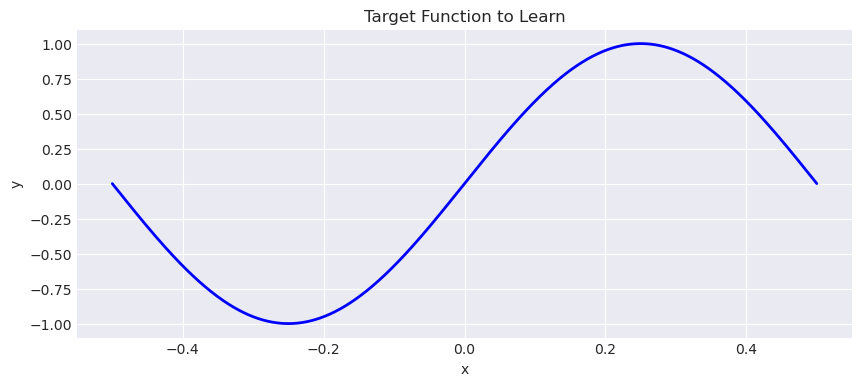

Training samples: 1000
Test samples: 5000
x range: [-0.5, 0.5]


In [2]:
# Define target function
def target_function(x):
    """Smooth sinusoidal function with clear structure"""
    return np.sin(2 * np.pi * x)

# Generate training data
x_train_np = np.linspace(-0.5, 0.5, 1000)
y_train_np = target_function(x_train_np)

# Generate test data (denser for smooth plotting)
x_test_np = np.linspace(-0.5, 0.5, 5000)
y_test_np = target_function(x_test_np)

# Convert to PyTorch tensors
x_train = torch.FloatTensor(x_train_np).reshape(-1, 1)
y_train = torch.FloatTensor(y_train_np).reshape(-1, 1)
x_test = torch.FloatTensor(x_test_np).reshape(-1, 1)
y_test = torch.FloatTensor(y_test_np).reshape(-1, 1)

# Create DataLoader for training
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Visualize the target function
plt.figure(figsize=(10, 4))
plt.plot(x_train_np, y_train_np, 'b-', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Target Function to Learn')
plt.show()

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"x range: [{x_train_np.min():.1f}, {x_train_np.max():.1f}]")

Below we define and train the two MLPs. They differ effectively in nothign other than activation function. We track validation set loss to avoid overfitting. 

In [3]:
# ReLU Network (piecewise linear, no bias)
class Network_ReLU(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.layer1 = nn.Linear(1, hidden_size, bias=True)
        self.layer2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer3 = nn.Linear(hidden_size, 1, bias=True)
        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

# SiLU Network (smooth/curvy, no bias)
class Network_SiLU(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.layer1 = nn.Linear(1, hidden_size, bias=True)
        self.layer2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer3 = nn.Linear(hidden_size, 1, bias=True)
        self.activation = nn.SiLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize both networks
net_relu = Network_ReLU(hidden_size=64)
net_silu = Network_SiLU(hidden_size=64)

print("ReLU Network (Piecewise Linear, No Bias):")
print(net_relu)
print(f"Total parameters: {sum(p.numel() for p in net_relu.parameters())}")

print("\n" + "="*60)

print("\nSiLU Network (Smooth/Curvy, No Bias):")
print(net_silu)
print(f"Total parameters: {sum(p.numel() for p in net_silu.parameters())}")

ReLU Network (Piecewise Linear, No Bias):
Network_ReLU(
  (layer1): Linear(in_features=1, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
)
Total parameters: 4353


SiLU Network (Smooth/Curvy, No Bias):
Network_SiLU(
  (layer1): Linear(in_features=1, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (activation): SiLU()
)
Total parameters: 4353


Training ReLU Network with Validation...
Epoch 100/100, Train Loss: 0.000008, Val Loss: 0.000004

Training SiLU Network with Validation...
Epoch 100/100, Train Loss: 0.000031, Val Loss: 0.000027


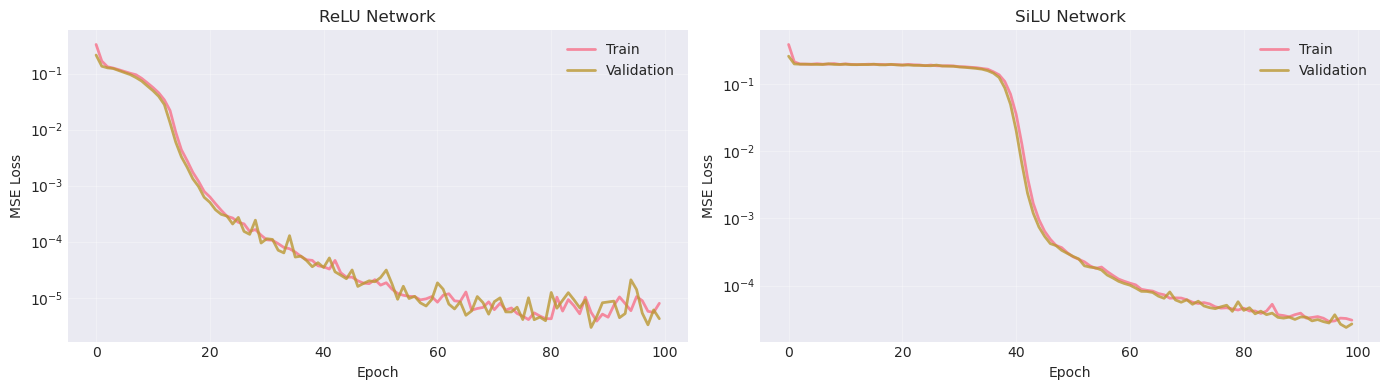


ReLU - Final Train Loss: 0.000008, Final Val Loss: 0.000004
SiLU - Final Train Loss: 0.000031, Final Val Loss: 0.000027


In [4]:
def train_network_with_validation(model, train_loader, x_val, y_val, epochs=50, lr=0.01, print_every=100):
    """Train a network with validation tracking"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(x_val)
            val_loss = criterion(val_pred, y_val).item()
            val_losses.append(val_loss)

        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")

    return train_losses, val_losses

# Retrain both networks with validation tracking
net_relu = Network_ReLU(hidden_size=64)
net_silu = Network_SiLU(hidden_size=64)

print("Training ReLU Network with Validation...")
print("="*60)
train_losses_relu, val_losses_relu = train_network_with_validation(
    net_relu, train_loader, x_test, y_test, epochs=100, lr=0.001
)

print("\n" + "="*60)
print("Training SiLU Network with Validation...")
print("="*60)
train_losses_silu, val_losses_silu = train_network_with_validation(
    net_silu, train_loader, x_test, y_test, epochs=100, lr=0.001
)

# Plot training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# ReLU
ax1.plot(train_losses_relu, label='Train', linewidth=2, alpha=0.8)
ax1.plot(val_losses_relu, label='Validation', linewidth=2, alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('ReLU Network')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# SiLU
ax2.plot(train_losses_silu, label='Train', linewidth=2, alpha=0.8)
ax2.plot(val_losses_silu, label='Validation', linewidth=2, alpha=0.8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE Loss')
ax2.set_title('SiLU Network')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReLU - Final Train Loss: {train_losses_relu[-1]:.6f}, Final Val Loss: {val_losses_relu[-1]:.6f}")
print(f"SiLU - Final Train Loss: {train_losses_silu[-1]:.6f}, Final Val Loss: {val_losses_silu[-1]:.6f}")

The loss curves look good, now to check how well the model output actually matches the original function.

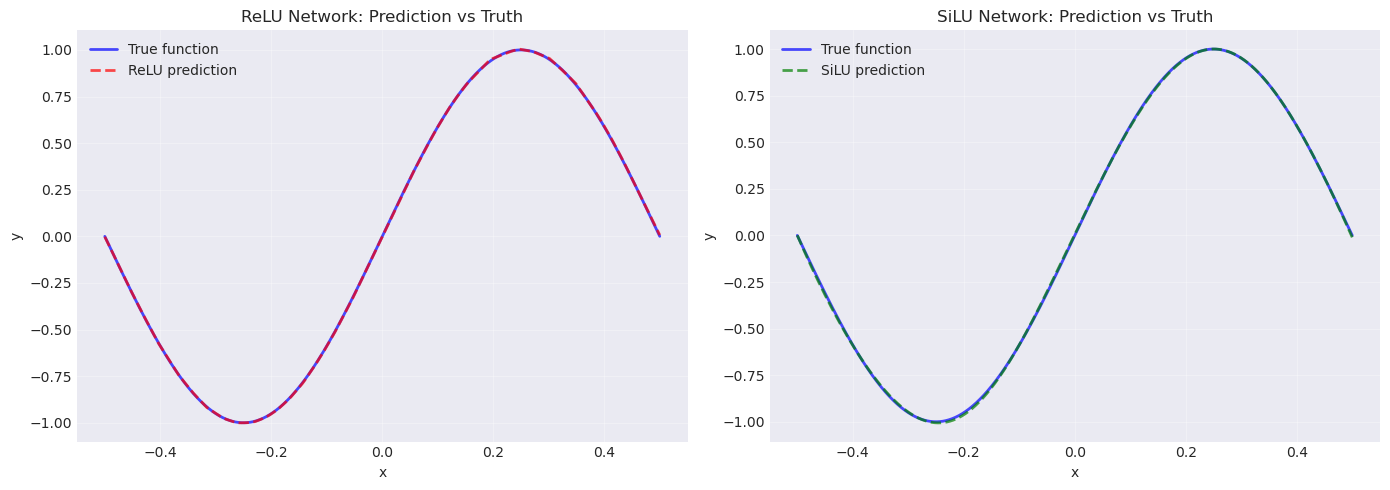

ReLU Network R²: 1.0000
SiLU Network R²: 0.9999


In [5]:
# Get predictions on test set
net_relu.eval()
net_silu.eval()

with torch.no_grad():
    y_pred_relu = net_relu(x_test).numpy()
    y_pred_silu = net_silu(x_test).numpy()

y_test_np = y_test.numpy()
x_test_np = x_test.numpy()

# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ReLU Network
axes[0].plot(x_test_np, y_test_np, 'b-', linewidth=2, label='True function', alpha=0.7)
axes[0].plot(x_test_np, y_pred_relu, 'r--', linewidth=2, label='ReLU prediction', alpha=0.7)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('ReLU Network: Prediction vs Truth')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SiLU Network
axes[1].plot(x_test_np, y_test_np, 'b-', linewidth=2, label='True function', alpha=0.7)
axes[1].plot(x_test_np, y_pred_silu, 'g--', linewidth=2, label='SiLU prediction', alpha=0.7)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('SiLU Network: Prediction vs Truth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute R² scores
from sklearn.metrics import r2_score
r2_relu = r2_score(y_test_np, y_pred_relu)
r2_silu = r2_score(y_test_np, y_pred_silu)

print(f"ReLU Network R²: {r2_relu:.4f}")
print(f"SiLU Network R²: {r2_silu:.4f}")

Looks pretty spot on across the entire domain of the training data. 

## Taylor series approximation

Now that we have our models we can start testing how well first/second order TSA can predict model output. Starting with first order TSA we can calculate the jacobian of the model for a given intput/ouput point and then use it to predict other model outputs around this starting point. Below a couple plots illustrate this by picking a random point on our function and plotting the line that first order TSA uses to approximate the function.

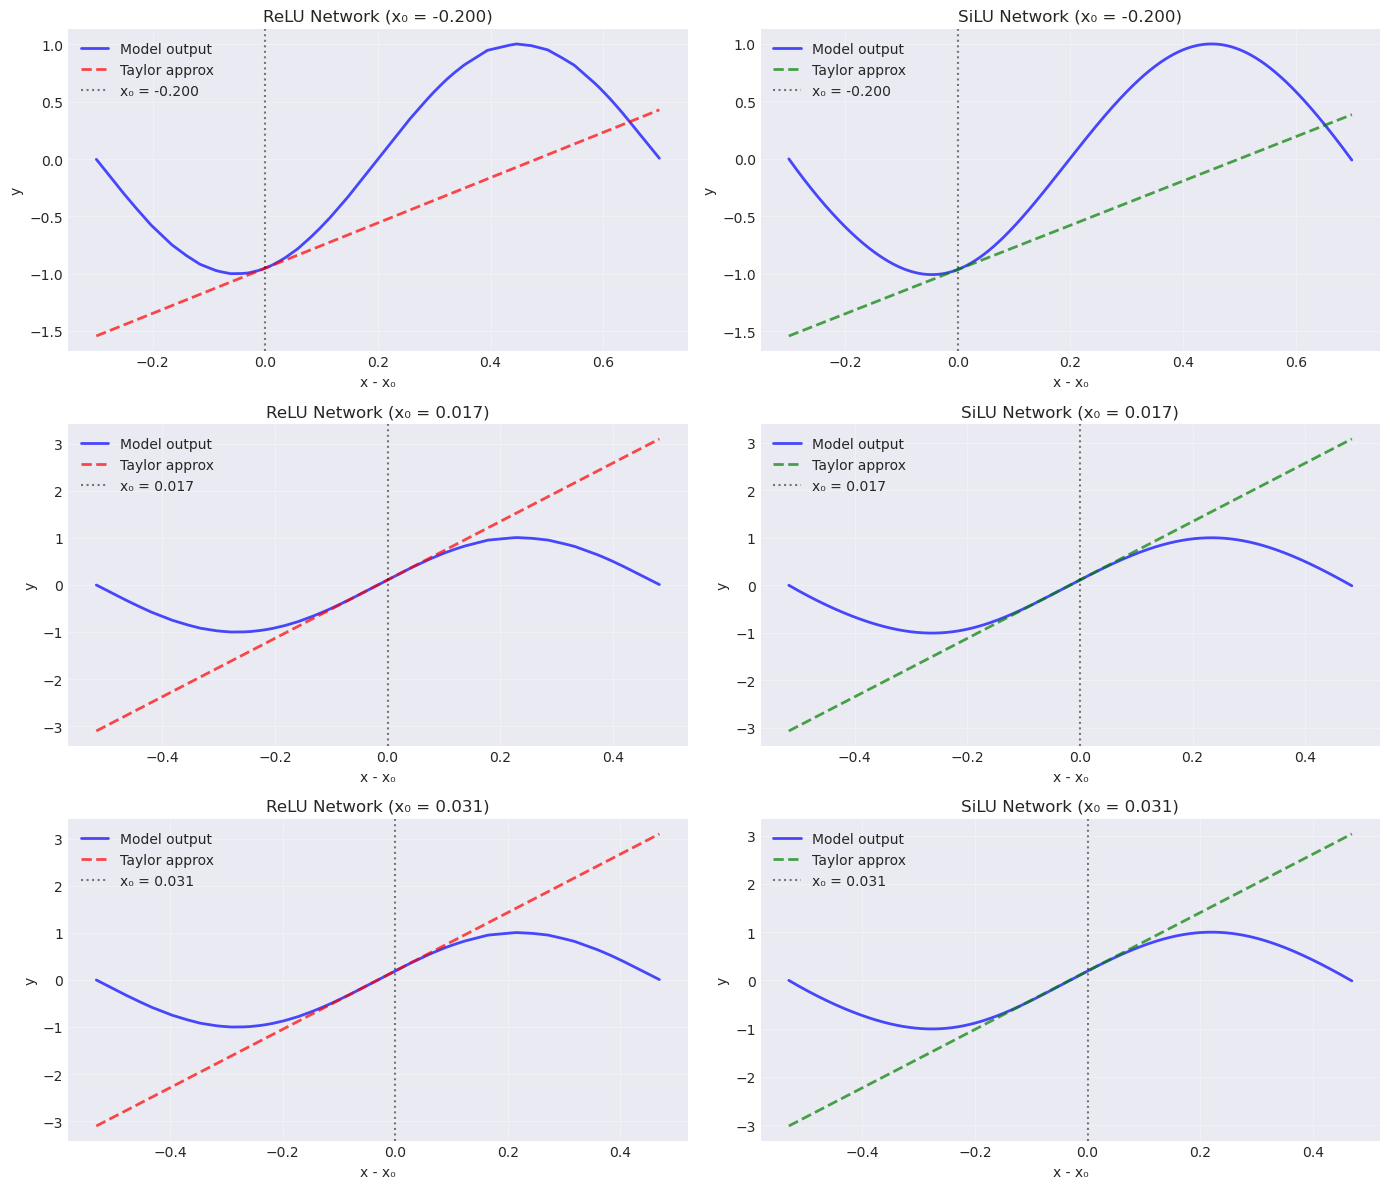

In [6]:
def compute_jacobian(model, x):
    """Compute Jacobian (gradient) at point x"""
    model.eval()
    x_torch = torch.tensor([[x]], dtype=torch.float32, requires_grad=True)
    y = model(x_torch)

    # Compute gradient
    y.backward()
    jacobian = x_torch.grad.item()

    return jacobian, y.item()

def taylor_approximation_analysis(model, x0, x_test, y_test):
    """
    Compute first-order Taylor approximation from x0 across all test points

    Returns:
    - distances: |x - x0| for all test points
    - errors: |f(x) - Taylor(x)| for all test points
    - y_taylor: Taylor predictions
    - y_actual: Actual model predictions
    """
    model.eval()

    # Get Jacobian and function value at x0
    J_x0, f_x0 = compute_jacobian(model, x0)

    # Compute Taylor approximation for all test points
    with torch.no_grad():
        y_actual = model(x_test).numpy().flatten()

    x_test_np = x_test.numpy().flatten()

    # First-order Taylor: f(x) ≈ f(x0) + J(x0) * (x - x0)
    y_taylor = f_x0 + J_x0 * (x_test_np - x0)

    # Compute distances and errors
    distances = np.abs(x_test_np - x0)
    errors = np.abs(y_actual - y_taylor)

    return distances, errors, y_taylor, y_actual

def plot_taylor_comparison(n_samples=5):
    """
    Plot Taylor approximation analysis for n random starting points
    Compares ReLU vs SiLU networks side by side
    """
    # Select random starting points from test set
    random_indices = np.random.choice(len(x_test), n_samples, replace=False)
    x0_values = x_test[random_indices].numpy().flatten()

    fig, axes = plt.subplots(n_samples, 2, figsize=(14, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, x0 in enumerate(x0_values):
        # Get Taylor approximation data for both models
        dist_relu, err_relu, y_taylor_relu, y_actual_relu = taylor_approximation_analysis(
            net_relu, x0, x_test, y_test
        )
        dist_silu, err_silu, y_taylor_silu, y_actual_silu = taylor_approximation_analysis(
            net_silu, x0, x_test, y_test
        )

        # Normalize x-axis to have x0 at 0
        x_normalized = x_test.numpy().flatten() - x0

        # Plot ReLU
        ax_relu = axes[i, 0]
        ax_relu.plot(x_normalized, y_actual_relu, 'b-', linewidth=2,
                    label='Model output', alpha=0.7)
        ax_relu.plot(x_normalized, y_taylor_relu, 'r--', linewidth=2,
                    label='Taylor approx', alpha=0.7)
        ax_relu.axvline(x=0, color='black', linestyle=':', alpha=0.5, label=f'x₀ = {x0:.3f}')
        ax_relu.set_xlabel('x - x₀')
        ax_relu.set_ylabel('y')
        ax_relu.set_title(f'ReLU Network (x₀ = {x0:.3f})')
        ax_relu.legend()
        ax_relu.grid(True, alpha=0.3)

        # Plot SiLU
        ax_silu = axes[i, 1]
        ax_silu.plot(x_normalized, y_actual_silu, 'b-', linewidth=2,
                    label='Model output', alpha=0.7)
        ax_silu.plot(x_normalized, y_taylor_silu, 'g--', linewidth=2,
                    label='Taylor approx', alpha=0.7)
        ax_silu.axvline(x=0, color='black', linestyle=':', alpha=0.5, label=f'x₀ = {x0:.3f}')
        ax_silu.set_xlabel('x - x₀')
        ax_silu.set_ylabel('y')
        ax_silu.set_title(f'SiLU Network (x₀ = {x0:.3f})')
        ax_silu.legend()
        ax_silu.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Test with 3 random starting points
plot_taylor_comparison(n_samples=3)

Unsurprisingly beyond a local neighborhood the first order TSA approximation is terrible for either model since the true function is highly nonlinear. Although how local this neighborhood is depends on where you land on the function since the middle is more linear than the peak/trough.

Below we do the same thing but now we include the Hessian of the model too, giving us a second order TSA. The Hessian of the leaky ReLU will be zero (so this approximation will be identical to the first order), but not for the SiLU.

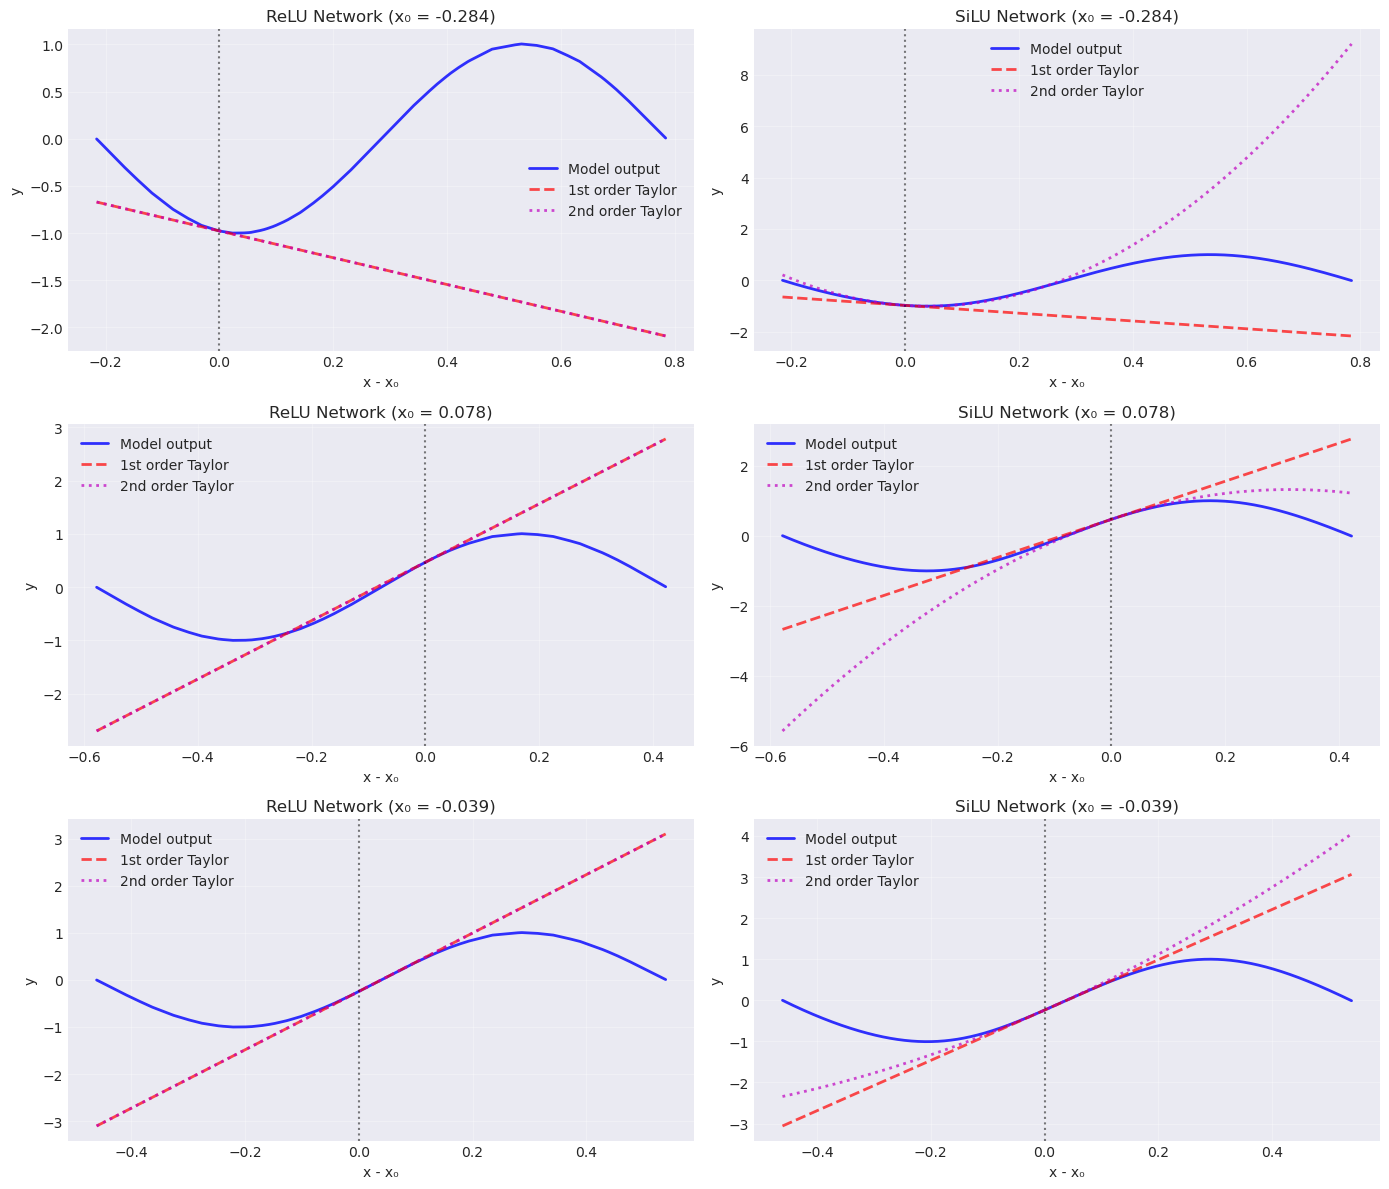

In [7]:
def compute_hessian(model, x):
    """Compute Hessian (second derivative) at point x for 1D input"""
    model.eval()

    # First derivative
    x_torch = torch.tensor([[x]], dtype=torch.float32, requires_grad=True)
    y = model(x_torch)

    # Compute first derivative
    grad_y = torch.autograd.grad(y, x_torch, create_graph=True)[0]

    # Compute second derivative
    hessian = torch.autograd.grad(grad_y, x_torch)[0]

    return hessian.item()

def taylor_approximation_analysis_second_order(model, x0, x_test, y_test):
    """
    Compute second-order Taylor approximation from x0 across all test points

    Returns:
    - distances: |x - x0| for all test points
    - errors_first: |f(x) - Taylor_1st(x)| for all test points
    - errors_second: |f(x) - Taylor_2nd(x)| for all test points
    - y_taylor_1st: First-order Taylor predictions
    - y_taylor_2nd: Second-order Taylor predictions
    - y_actual: Actual model predictions
    """
    model.eval()

    # Get Jacobian, Hessian, and function value at x0
    J_x0, f_x0 = compute_jacobian(model, x0)
    H_x0 = compute_hessian(model, x0)

    # Compute predictions for all test points
    with torch.no_grad():
        y_actual = model(x_test).numpy().flatten()

    x_test_np = x_test.numpy().flatten()
    delta_x = x_test_np - x0

    # First-order Taylor: f(x) ≈ f(x0) + J(x0) * (x - x0)
    y_taylor_1st = f_x0 + J_x0 * delta_x

    # Second-order Taylor: f(x) ≈ f(x0) + J(x0) * (x - x0) + 0.5 * H(x0) * (x - x0)²
    y_taylor_2nd = f_x0 + J_x0 * delta_x + 0.5 * H_x0 * (delta_x ** 2)

    # Compute distances and errors
    distances = np.abs(delta_x)
    errors_first = np.abs(y_actual - y_taylor_1st)
    errors_second = np.abs(y_actual - y_taylor_2nd)

    return distances, errors_first, errors_second, y_taylor_1st, y_taylor_2nd, y_actual

def plot_taylor_comparison_with_second_order(n_samples=3):
    """
    Plot Taylor approximation analysis (1st and 2nd order) for n random starting points
    Compares ReLU vs SiLU networks side by side
    """
    # Select random starting points from test set
    random_indices = np.random.choice(len(x_test), n_samples, replace=False)
    x0_values = x_test[random_indices].numpy().flatten()

    fig, axes = plt.subplots(n_samples, 2, figsize=(14, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)

    for i, x0 in enumerate(x0_values):
        # Get Taylor approximation data for both models
        dist_relu, err1_relu, err2_relu, y_tay1_relu, y_tay2_relu, y_act_relu = \
            taylor_approximation_analysis_second_order(net_relu, x0, x_test, y_test)

        dist_silu, err1_silu, err2_silu, y_tay1_silu, y_tay2_silu, y_act_silu = \
            taylor_approximation_analysis_second_order(net_silu, x0, x_test, y_test)

        # Normalize x-axis to have x0 at 0
        x_normalized = x_test.numpy().flatten() - x0

        # Plot ReLU
        ax_relu = axes[i, 0]
        ax_relu.plot(x_normalized, y_act_relu, 'b-', linewidth=2,
                    label='Model output', alpha=0.8)
        ax_relu.plot(x_normalized, y_tay1_relu, 'r--', linewidth=2,
                    label='1st order Taylor', alpha=0.7)
        ax_relu.plot(x_normalized, y_tay2_relu, 'm:', linewidth=2,
                    label='2nd order Taylor', alpha=0.7)
        ax_relu.axvline(x=0, color='black', linestyle=':', alpha=0.5)
        ax_relu.set_xlabel('x - x₀')
        ax_relu.set_ylabel('y')
        ax_relu.set_title(f'ReLU Network (x₀ = {x0:.3f})')
        ax_relu.legend()
        ax_relu.grid(True, alpha=0.3)

        # Plot SiLU
        ax_silu = axes[i, 1]
        ax_silu.plot(x_normalized, y_act_silu, 'b-', linewidth=2,
                    label='Model output', alpha=0.8)
        ax_silu.plot(x_normalized, y_tay1_silu, 'r--', linewidth=2,
                    label='1st order Taylor', alpha=0.7)
        ax_silu.plot(x_normalized, y_tay2_silu, 'm:', linewidth=2,
                    label='2nd order Taylor', alpha=0.7)
        ax_silu.axvline(x=0, color='black', linestyle=':', alpha=0.5)
        ax_silu.set_xlabel('x - x₀')
        ax_silu.set_ylabel('y')
        ax_silu.set_title(f'SiLU Network (x₀ = {x0:.3f})')
        ax_silu.legend()
        ax_silu.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Test with 3 random starting points
plot_taylor_comparison_with_second_order(n_samples=3)

You can see how the second order TSA seems to give the SiLU a better ability to project out further from the starting point especially in curvier parts of the function domain. 

Let's do a more concrete visualisation below though. What the plots below show is the difference in error in predicting model output (*not* error in predicting the truefunction). This is shown for both first (left) and second (right) order TSA. Positive values indicate the leaky ReLU has lower TSA reconstruction error, i.e. the TSA is doing a better job of predicting the ReLU model's output than the SiLU's. We pick 100 random starting points from our validation set (this starting point is standardized to 0 on the x axis) and explore a local neighborhood of varying size around them. What do we see?

In [8]:
def plot_taylor_error_comparison_second_order(n_samples=5, domain_range=0.2):
    """
    Plot the difference in Taylor approximation error (1st and 2nd order) between SiLU and ReLU models

    Parameters:
    - n_samples: number of random starting points to test
    - domain_range: +/- range around x0 to evaluate (e.g., 0.2 means -0.2 to +0.2)
    """
    # Select random starting points from test set
    random_indices = np.random.choice(len(x_test), n_samples, replace=False)
    x0_values = x_test[random_indices].numpy().flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Define color map for different starting points
    colors = plt.cm.viridis(np.linspace(0, 0.9, n_samples))

    for idx, x0 in enumerate(x0_values):
        # Filter test points to be within domain_range of x0
        mask = np.abs(x_test.numpy().flatten() - x0) <= domain_range
        x_test_local = x_test[mask]
        y_test_local = y_test[mask]

        # Get 2nd order Taylor approximation errors for both models
        dist_relu, err1_relu, err2_relu, y_tay1_relu, y_tay2_relu, y_act_relu = \
            taylor_approximation_analysis_second_order(net_relu, x0, x_test_local, y_test_local)

        dist_silu, err1_silu, err2_silu, y_tay1_silu, y_tay2_silu, y_act_silu = \
            taylor_approximation_analysis_second_order(net_silu, x0, x_test_local, y_test_local)

        # Normalize x-axis to have x0 at 0
        x_normalized = x_test_local.numpy().flatten() - x0

        # Plot 1st order error difference (SiLU - ReLU)
        error_diff_1st = err1_silu - err1_relu
        ax1.plot(x_normalized, error_diff_1st, '-', color=colors[idx],
                linewidth=2, alpha=0.7)

        # Plot 2nd order error difference (SiLU - ReLU)
        error_diff_2nd = err2_silu - err2_relu
        ax2.plot(x_normalized, error_diff_2nd, '-', color=colors[idx],
                linewidth=2, alpha=0.7)

    # Format 1st order error difference plot
    ax1.axvline(x=0, color='black', linestyle=':', alpha=0.5, linewidth=1)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax1.set_xlabel('x - x₀', fontsize=12)
    ax1.set_ylabel('Error(SiLU) - Error(ReLU)', fontsize=12)
    ax1.set_title('1st Order Taylor: Error Difference\n(positive = SiLU worse)', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Format 2nd order error difference plot
    ax2.axvline(x=0, color='black', linestyle=':', alpha=0.5, linewidth=1)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax2.set_xlabel('x - x₀', fontsize=12)
    ax2.set_ylabel('Error(SiLU) - Error(ReLU)', fontsize=12)
    ax2.set_title('2nd Order Taylor: Error Difference\n(positive = SiLU worse)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


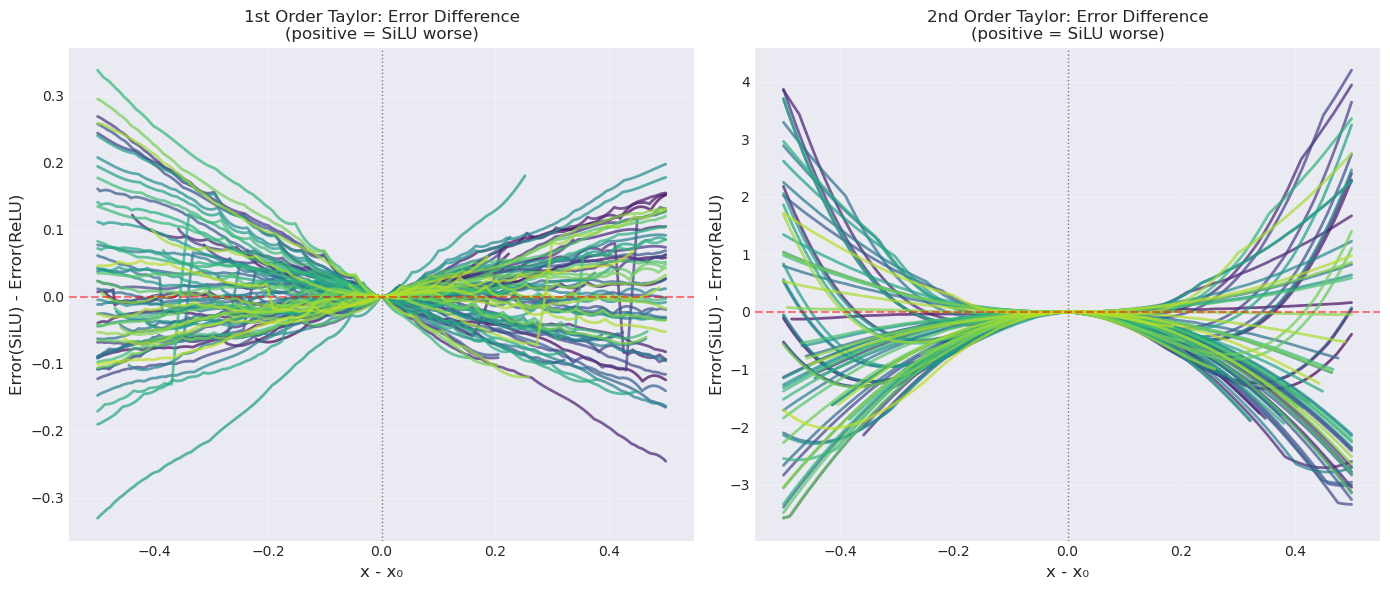

In [9]:
plot_taylor_error_comparison_second_order(n_samples=100, domain_range=0.5)

We start off with pushing the TSA to project quite far from the starting point (+/- 0.5). In the first order case is sort of seems like a wash with both activation functions as TSA faily miserably the further out you project from the start. However in the second order TSA we get some fairly consistent curvature. At short/intermediate distances SiLU does seem to dominate as the Hessian allows TSA to track the curvature of the true function learned by the network. However at large distance this falls apart as the curvature of the Hessian starts to diverge from the true function leading to huge errors.  

Note the distinct peaking in first order TSA plot. These are almost certainly shadows of the boundaries where the leaky ReLU activation functions switch from one piecwise linear regime to another. At those boundaries error spikes as the Jacobian (which is frozen to the gradiant at the starting point) faily to match the new linear regime.  

What happens as we progressively narrow the domain we inspect? 

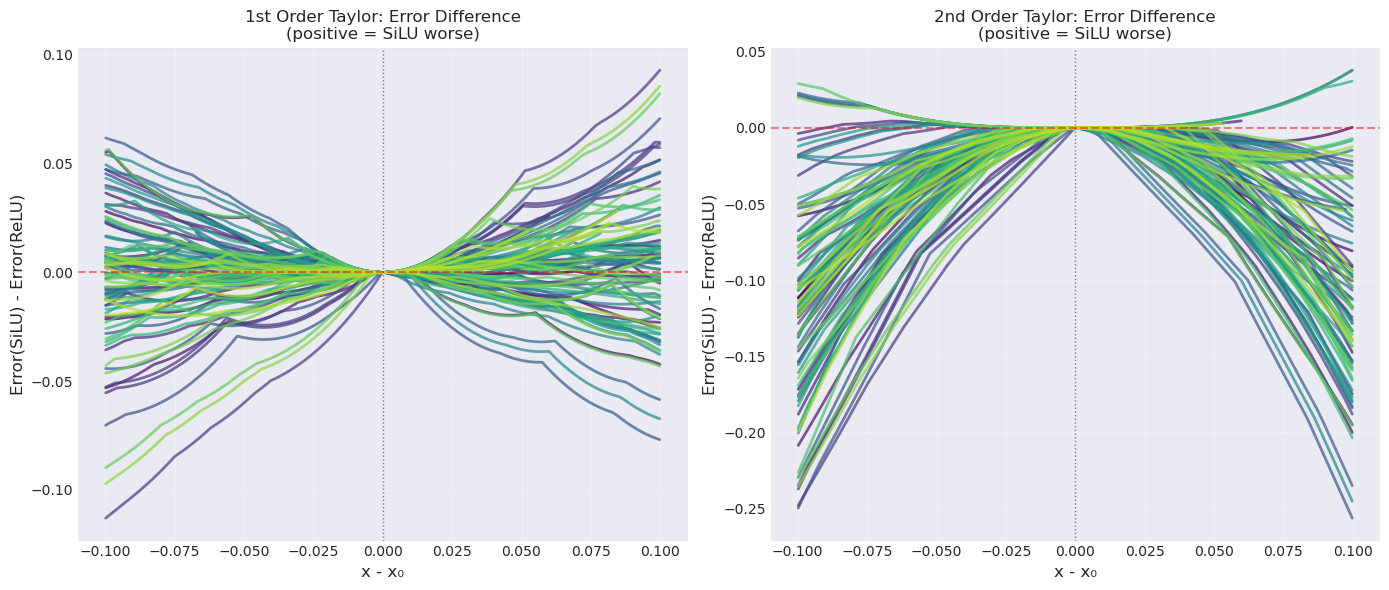

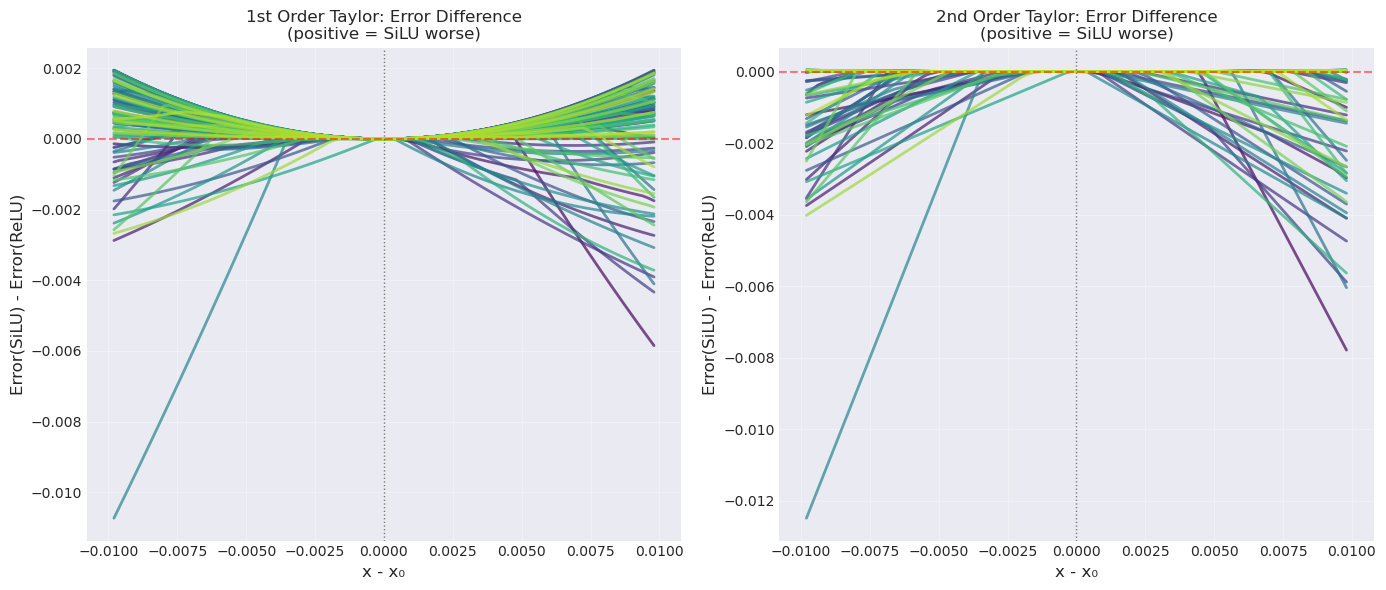

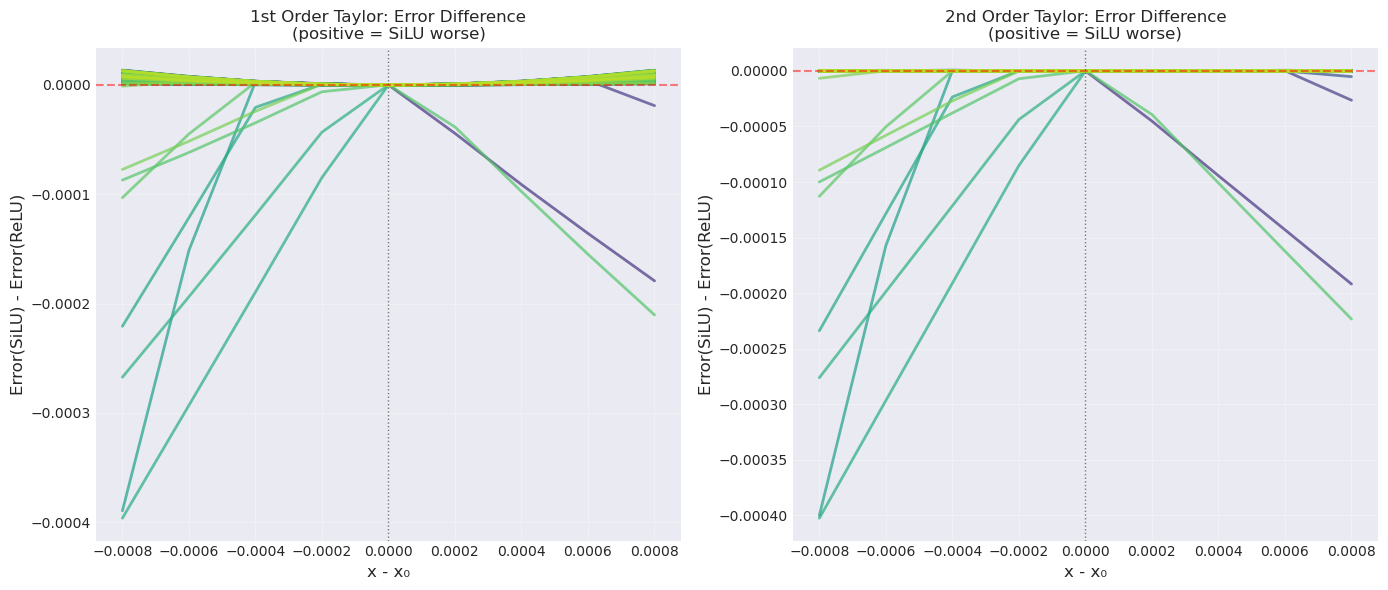

In [10]:
plot_taylor_error_comparison_second_order(n_samples=100, domain_range=0.1)
plot_taylor_error_comparison_second_order(n_samples=100, domain_range=0.01)
plot_taylor_error_comparison_second_order(n_samples=100, domain_range=0.001)

Some fairly consistent and interesting patterns emerge as we narrow the range of the domain where we track the error of TSA. 

Let's start with the first order TSA. You can see that as we narrow the range, more and more of our prediction lie just above $y=0$ indicating the slight superiorty of TSA for the leaky ReLU. I think this is the signal of the initial hypothesis. In a local neighborhood when you don't cross any activation boundaries, first order TSA is naturally a bit better when applied to leaky ReLU rather than SiLU activation function models. However, the key component is not crossing an activation boundary. Since those are so rough in the leaky ReLU case, when by chance you do cross a boundary, you get very high error rates for TSA which is why we get the occasional line well below $y=0$. 

What about second order TSA?
Here the superiority of the SiLU really starts to shine. Basically in all ranges this activation function is better captured by second order TSA. As we get to extremely narrow ranges, where the leaky ReLU used to slightly edge out the SiLU due to it's curvature we effectively get parity in TSA approximation between the activation functions since the Hessian allows TSA to capture said curvature. 

So what does this imply? In a very narrow neighborhood, matching the order of TSA to your activation function makes sense. But there are nuances around crossing sharp activation boundaries for activation functions like leaky ReLU. The more nonlinear the point in the input domain you are performing the TSA at, the faster things go awry. 

This naturally begs the question of whether we can visualise this effect. In fact, by mapping points of sharp error increase of TSA for the leaky ReLU we should be able to find simple activation boundaries in our sample training task. Below we plot the original function, and relative TSA error from random points across the domain (in a narrow range).

In [20]:
def plot_taylor_error_with_function(model, target_func, n_samples=250, neighborhood=0.01):
    """
    Plot Taylor approximation error overlaid on the actual function
    Shows how boundaries relate to function curvature

    Parameters:
    - model: the neural network to analyze
    - target_func: the true function (for comparison)
    - n_samples: number of random starting points
    - neighborhood: +/- range around each x0 to test
    """
    # Select random starting points across the domain
    x0_values = np.random.uniform(-0.4, 0.4, n_samples)

    # Create figure with two subplots sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [1, 1.5]})

    # Define color map for error lines
    colors = plt.cm.viridis(np.linspace(0, 0.9, n_samples))

    # Plot 1: The actual function and model fit
    x_dense = np.linspace(-0.5, 0.5, 1000)
    y_true = target_func(x_dense)

    with torch.no_grad():
        y_model = [model(torch.tensor([[x]], dtype=torch.float32)).item()
                   for x in x_dense]

    ax1.plot(x_dense, y_true, 'b-', linewidth=3, label='True function: sin(2πx)', alpha=0.7)
    ax1.plot(x_dense, y_model, 'r--', linewidth=2, label='ReLU network', alpha=0.7)
    ax1.set_ylabel('Function value', fontsize=12)
    ax1.set_title('Function Approximation and Taylor Error Analysis', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Taylor errors in absolute coordinates
    for idx, x0 in enumerate(x0_values):
        # Create test points in neighborhood of x0
        x_test_absolute = np.linspace(x0 - neighborhood,
                                      x0 + neighborhood,
                                      200)

        # Keep only points within domain
        mask = (x_test_absolute >= -0.5) & (x_test_absolute <= 0.5)
        x_test_absolute = x_test_absolute[mask]

        # Compute Taylor approximation from x0
        J_x0, f_x0 = compute_jacobian(model, x0)

        # Get actual model outputs and compute error
        errors = []
        for x in x_test_absolute:
            y_act = model(torch.tensor([[x]], dtype=torch.float32)).item()
            y_tay = f_x0 + J_x0 * (x - x0)
            error = y_act - y_tay  # Signed error
            errors.append(error)

        errors = np.array(errors)

        # Plot error vs ABSOLUTE x position
        ax2.plot(x_test_absolute, errors, '-', color=colors[idx],
                linewidth=1.5, alpha=0.6)

        # Mark the starting point
        ax2.scatter([x0], [0], color=colors[idx], s=15, alpha=0.8, zorder=5)

    # Add reference line
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

    # Formatting
    ax2.set_xlabel('Absolute position in domain (x)', fontsize=13)
    ax2.set_ylabel('Signed Taylor Error\nf(x) - f_Taylor(x)', fontsize=12)
    ax2.set_title(f'{n_samples} starting points, each testing ±{neighborhood} neighborhood\n' +
                  'Vertical alignment of peaks = activation boundaries',
                  fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(-0.5, 0.5)

    plt.tight_layout()
    plt.show()


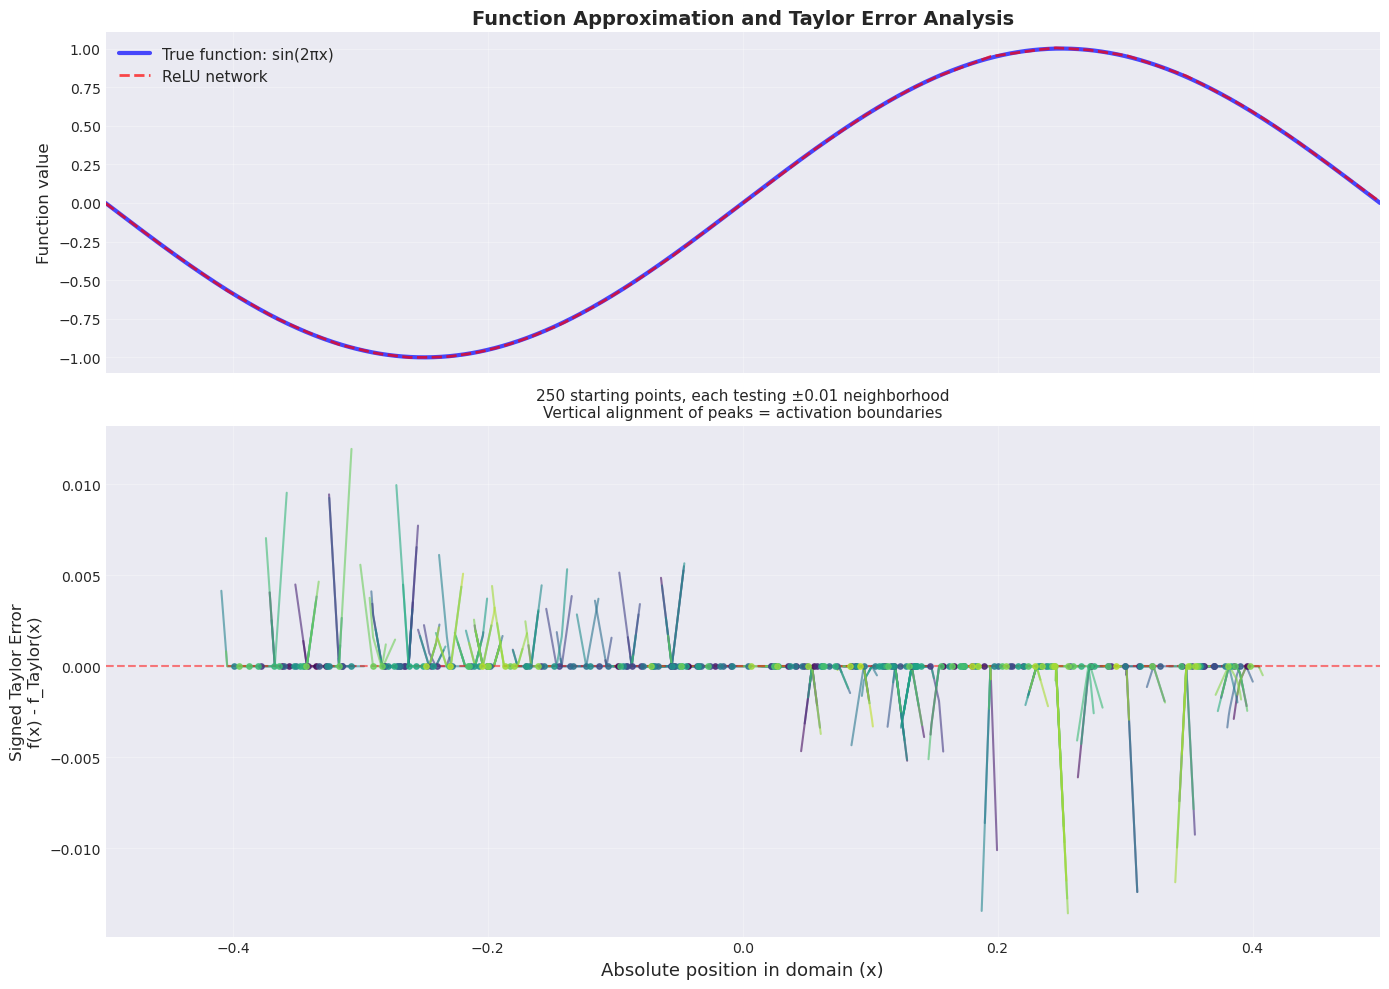

In [21]:
plot_taylor_error_with_function(net_relu, target_function, n_samples=250, neighborhood=0.01)

As we would expect, the TSA has pretty sharp error in the curvier parts of the function domain where the network has to have many breakpoints to match ground truth. While in the middle part where the function is linear, the TSA works perfectly even for longer distances since ground truth is linear.  